# 

# GIS (intro)

## What is GIS?

GIS stands for Geographic Information System. It is a system designed to capture, store, manipulate, analyze, manage, and present spatial or geographic data. In other words, GIS is used to create maps and analyze spatial data for a wide range of applications.

In this note, we'll cover some basic GIS concepts and tools that are useful for atmospheric science research.

## What we'll cover
- Define a bounding box of a map, using [geojson.io](http://geojson.io/)
- Download atmospheric data using [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)
- Plot bbox and atmosphere data on a map using [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)
- Repeat above steps, but with time-series data and animations using [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

In [ ]:
!uv pip install -r ../requirements.txt

from shapely.geometry import box
import earthkit
import folium
import geopandas as gpd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt


Using Python 3.12.4 environment at: /Users/per.morten.halvorsen@schibsted.com/personal/whale-gis/.venv
Audited 7 packages in 36ms


# Bounding Box

## Polygon

Used https://geojson.io/ to help defined polygon coordinates. 

[Example](https://geojson.io/#new&map=1.78/17.5/-136.2)
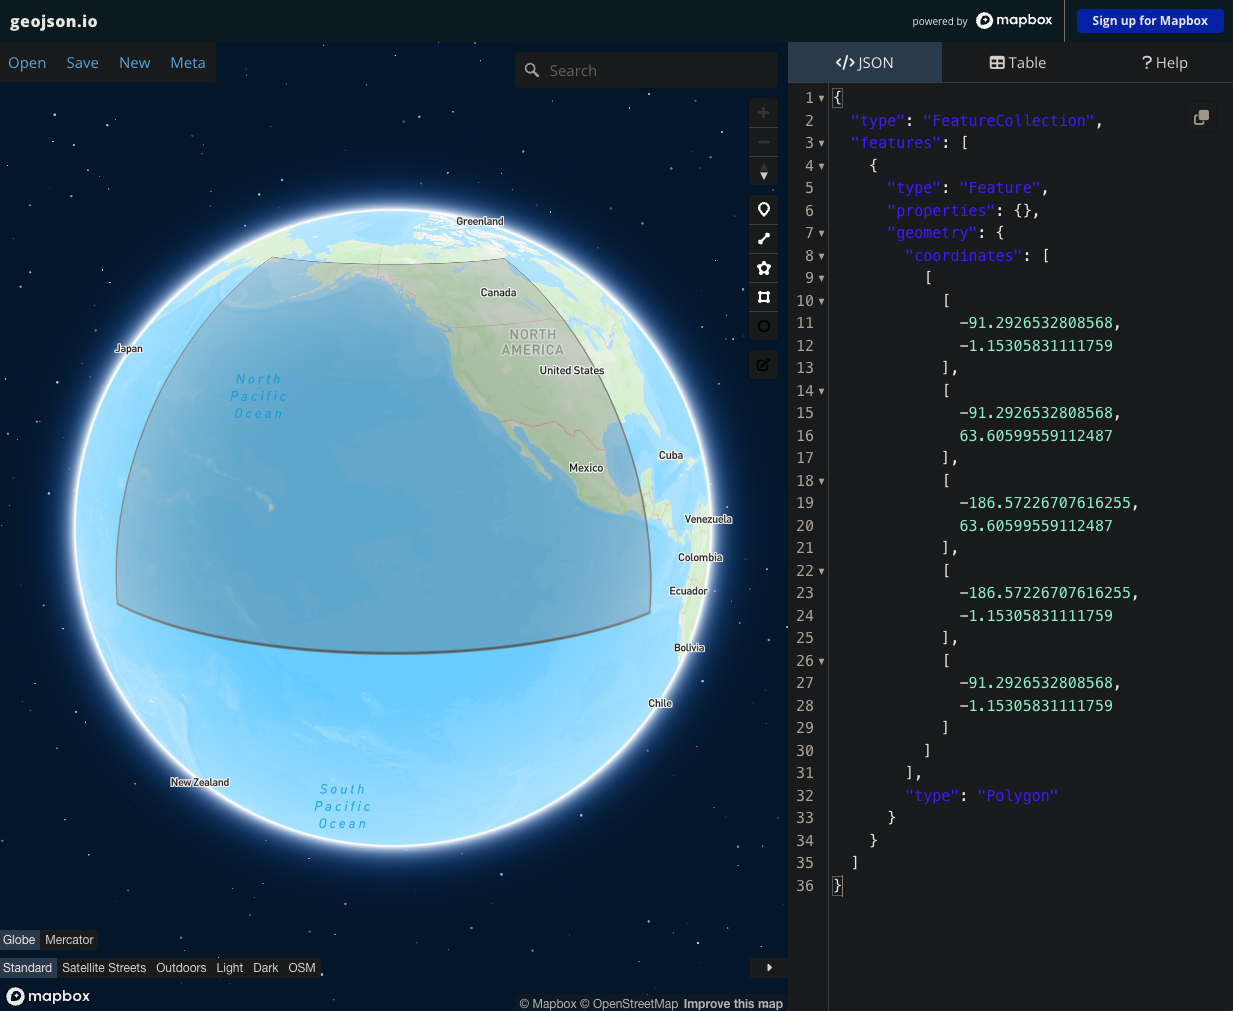

In [3]:
# Use the coordinates of the polygon created as a geometry feature
polygon =   [
    [
      -91.2926532808568,
      -1.15305831111759
    ],
    [
      -91.2926532808568,
      63.60599559112487
    ],
    [
      -186.57226707616255,
      63.60599559112487
    ],
    [
      -186.57226707616255,
      -1.15305831111759
    ],
    [
      -91.2926532808568,
      -1.15305831111759
    ]
]

### wider [polygon](https://geojson.io/#new&map=1.54/-62.1/-145)

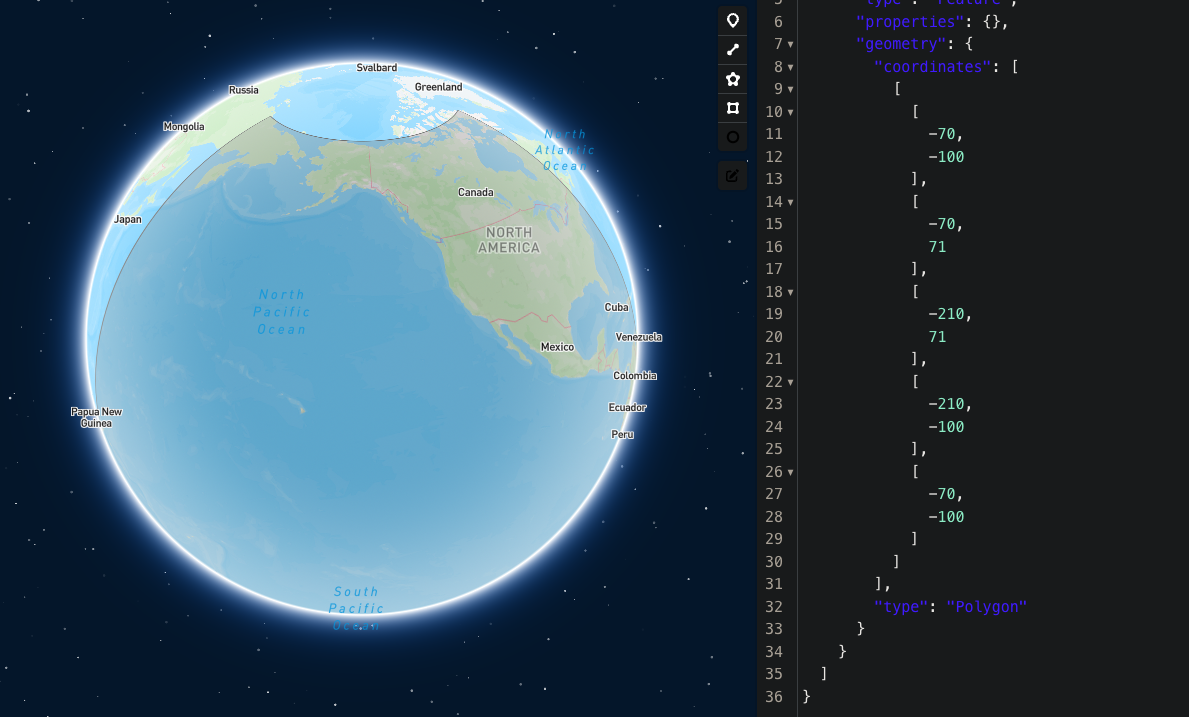
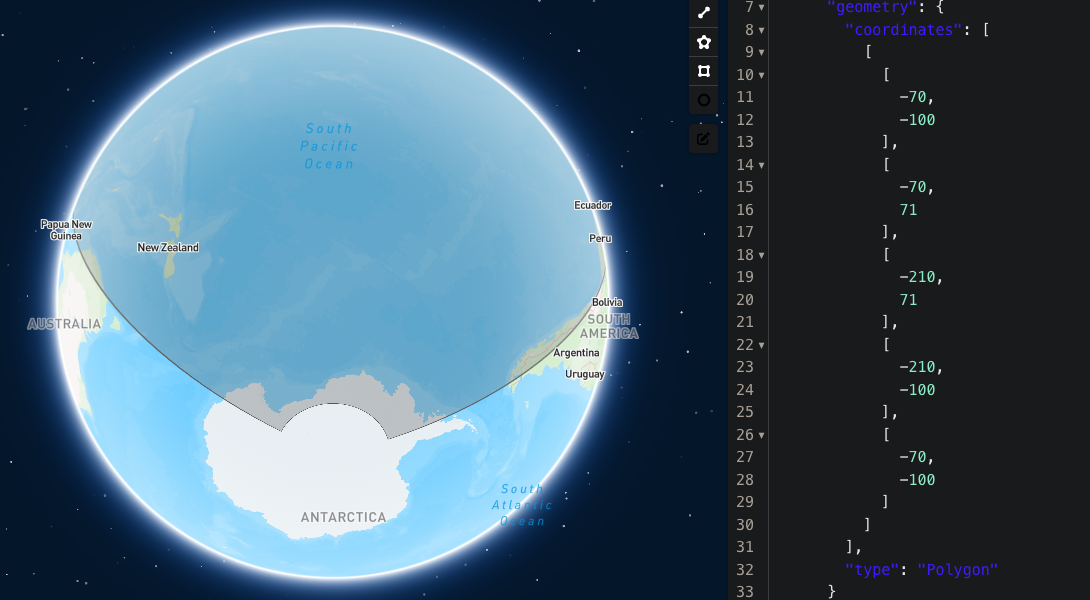

In [46]:
wide_polygon = [
    [
        -70,
        -100
    ],
    [
        -70,
        71
    ],
    [
        -210,
        71
    ],
    [
        -210,
        -100
    ],
    [
        -70,
        -100
    ]
]

## Coordinate utils 

Some helper functions to convert coordinates to bounding box and vice versa.


In [4]:
def nwse_to_latlon(n, w, s, e):
    """
    Convert north-west-south-east coordinates to latitude-longitude coordinates.
    """
    lat = (n + s) / 2
    lon = (w + e) / 2
    return lat, lon


def latlon_to_nwse(lat: tuple, lon: tuple):
    """
    Convert latitude-longitude coordinates to north-west-south-east coordinates.

    :params:
        lat: tuple, latitude
        lon: tuple, longitude
    """
    n = lat[0]
    s = lat[1]
    w = lon[0]
    e = lon[1]
    return n, w, s, e


def get_bbox(lat, lon, radius):
    """
    Get bounding box from latitude, longitude and radius.
    """
    n = lat + radius
    s = lat - radius
    w = lon - radius
    e = lon + radius
    return n, w, s, e


def polygon_to_nwse(poly):
    """
    Get bounding box from polygon.
    """
    lats = [p[1] for p in poly]
    lons = [p[0] for p in poly]
    n = max(lats)
    s = min(lats)
    w = min(lons)
    e = max(lons)
    return n, w, s, e


In [5]:
n,w,s,e = polygon_to_nwse(polygon)

lat, lon = nwse_to_latlon(n,w,s,e)

print("NWSE:", n,w,s,e)
print("LAT:", lat, "LON:", lon)

NWSE: 63.60599559112487 -186.57226707616255 -1.15305831111759 -91.2926532808568
LAT: 31.226468640003638 LON: -138.93246017850967


In [47]:
n,w,s,e = polygon_to_nwse(wide_polygon)

lat, lon = nwse_to_latlon(n,w,s,e)

print("NWSE:", n,w,s,e)
print("LAT:", lat, "LON:", lon)

NWSE: 71 -210 -100 -70
LAT: -14.5 LON: -140.0


# Atmospheric data w/ [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)

## API setup

In order to use this package, we needed to create an account to generate an API key, using the following link:
https://cds.climate.copernicus.eu/profile 



You can browse the different datasets available in the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/datasets/), where you'll need to request access to each dataset you'll like to access. In this note, we'll use the [CAMS global reanalysis (EAC4)](https://ads.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download) data.


When running the below code for the first time, you'll likely be asked to provide an API url and key. The key is found in your profile. For the athmosperic data, the endpoint is:
 `https://ads.atmosphere.copernicus.eu/api/`. 

## Download data

In [ ]:
# coords = polygon_to_nwse(polygon)
coords = polygon_to_nwse(wide_polygon)


ds = earthkit.data.from_source(
    "ads",
    "cams-global-reanalysis-eac4",
    variable=["particulate_matter_10um", "particulate_matter_1um", "2m_temperature", "mean_sea_level_pressure", "total_column_carbon_monoxide"],
    area=[*coords], # N, W, S, E
    date="2016-12-21",
    time="12:00",
)

ds

2024-12-23 18:36:53,580 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-23 18:36:53,581 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-23 18:36:53,734 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-

GRIBReader(/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/tmp6w532piy/ads-retriever-b2aba72556daef3eb53b793cf1263924e87d8323681d6347f2e062921265e257.cache)

### Load GRIB as xarray


In [7]:
# ds_xr = xr.open_dataset(ds.path, engine='cfgrib')
ds_xr = ds.to_xarray()
ds_xr

From version 0.11.0 the default engine for to_xarray is 'earthkit'. Use engine=`cfgrib` to invoke the cfgrib engine.


<xarray.Dataset> Size: 447kB
Dimensions:    (latitude: 87, longitude: 128)
Coordinates:
  * latitude   (latitude) float64 696B 63.35 62.6 61.85 ... 0.347 -0.403 -1.154
  * longitude  (longitude) float64 1kB 173.4 174.2 174.9 ... 267.2 267.9 268.7
Data variables:
    2t         (latitude, longitude) float64 89kB ...
    msl        (latitude, longitude) float64 89kB ...
    pm1        (latitude, longitude) float64 89kB ...
    pm10       (latitude, longitude) float64 89kB ...
    tcco       (latitude, longitude) float64 89kB ...
Attributes:
    class:        mc
    stream:       oper
    levtype:      sfc
    type:         an
    expver:       eac4
    date:         20161221
    time:         1200
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

In [8]:
ds_xr.coords

Coordinates:
  * latitude   (latitude) float64 696B 63.35 62.6 61.85 ... 0.347 -0.403 -1.154
  * longitude  (longitude) float64 1kB 173.4 174.2 174.9 ... 267.2 267.9 268.7

# Plot geo-data w/ [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)

## Bounding box

Read about WGS84 and EPSG:4326: https://gisgeography.com/wgs84-world-geodetic-system/

In [33]:
coords = polygon_to_nwse(polygon)


def draw_map_bbox(coords):
    n, w, s, e = coords
    lat, lon = nwse_to_latlon(n, w, s, e)
    # Create a GeoDataFrame with the bounding box (w, s, e, n)
    bbox = gpd.GeoDataFrame({'geometry': [box(w, s, e, n)]})

    # Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    bbox = bbox.set_crs(epsg=4326)

    # Create a folium map centered around the bounding box
    base_map = folium.Map(
        location=[
            lat, 
            lon
        ], 
        zoom_start=3
    )

    # Add the bounding box to the map
    folium.GeoJson(bbox).add_to(base_map)

    # Display the map
    return base_map


base_map = draw_map_bbox(coords)

# Display the map
base_map

## Climate data

In [51]:
def xr_to_nwse(xr):
    """
    Get north-west-south-east coordinates from xarray dataset.
    """
    lats = xr.latitude.values
    lons = xr.longitude.values
    n = float(max(lats))
    s = float(min(lats))
    w = float(min(lons))
    e = float(max(lons))
    return n, w, s, e

xr_to_nwse(ds_xr)

(63.347, 173.427, -1.154, 268.678)

### Particulate matter 10m (pm10)


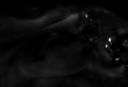

In [70]:
def draw_map_data(xr, variable, opacity=1.0):
    coords = xr_to_nwse(xr)

    map = draw_map_bbox(coords)

    data = xr[variable].values

    # Create a folium raster layer for pm10 data
    folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[
            [coords[2], coords[1]],  # n, w
            [coords[0], coords[3]]   # s, e
        ],
        # colormap=lambda x: (1, 0, 0, x),  # Red colormap
        opacity=opacity
    ).add_to(map)

    return map


draw_map_data(ds_xr, "pm10", 0.7)


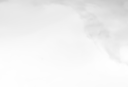

In [68]:

draw_map_data(ds_xr, "t2m", 0.7)


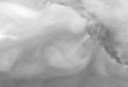

In [67]:
draw_map_data(ds_xr, "tcco", 0.7)

## Draw map for new polygon

## More plotting 

But with matplotlib

### xaray to matplotlib

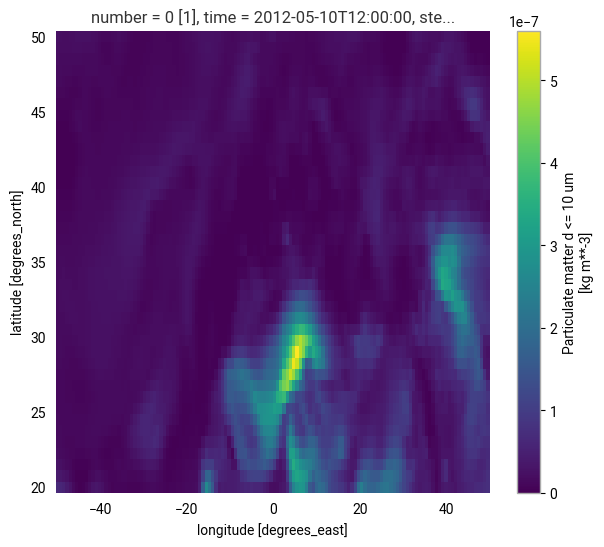

In [29]:
ds_xr["pm10"].plot()

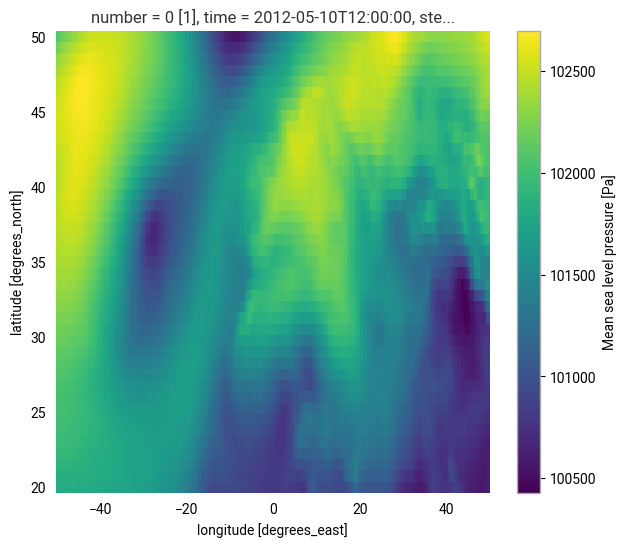

In [30]:
ds_xr["msl"].plot()

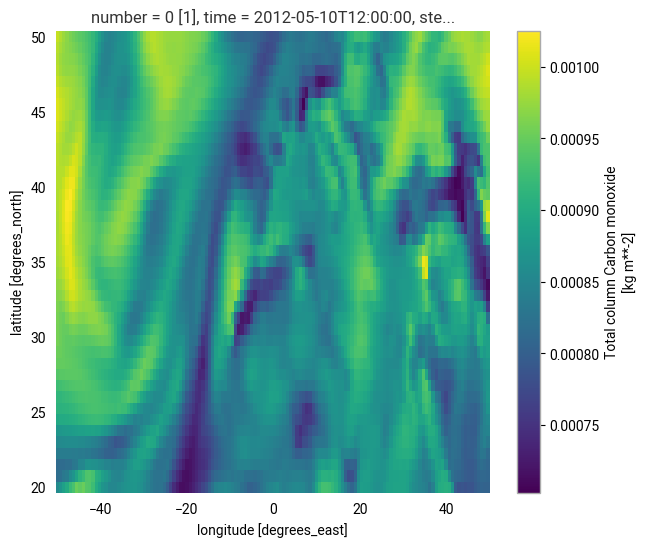

In [32]:
ds_xr["tcco"].plot()

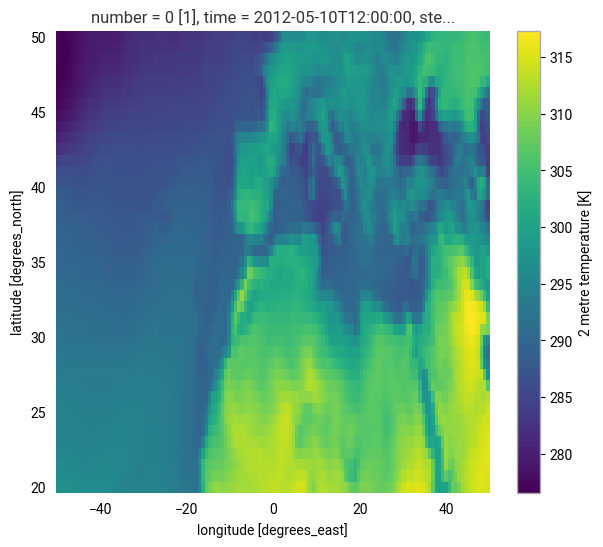

In [33]:
ds_xr["t2m"].plot()

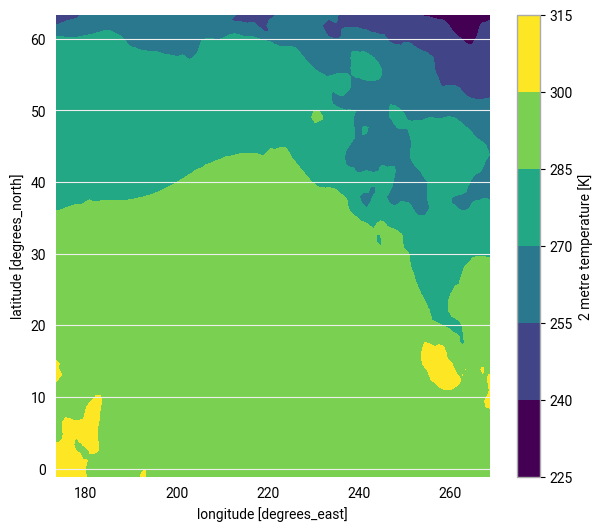

In [75]:
ds_xr["2t"].plot.contourf()

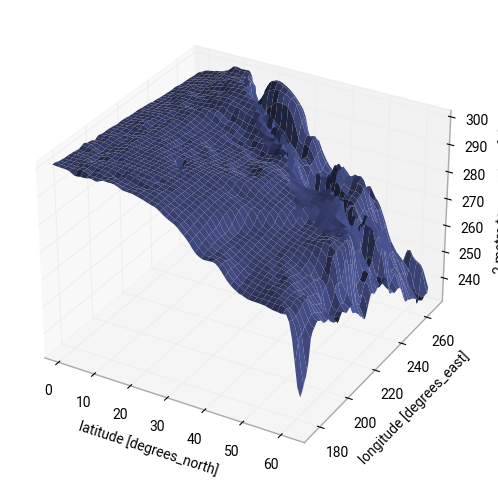

In [77]:
air2d = ds_xr["2t"]
air2d.T.plot.surface()

Plotting in x array 
https://docs.xarray.dev/en/stable/user-guide/plotting.html

In [73]:
lat_idx = 0
lon_idx = 0

lat, lon
ds_xr.isel(latitude=lat_idx, longitude=lon_idx)

<xarray.Dataset> Size: 56B
Dimensions:    ()
Coordinates:
    latitude   float64 8B 63.35
    longitude  float64 8B 173.4
Data variables:
    2t         float64 8B 244.1
    msl        float64 8B 1.008e+05
    pm1        float64 8B 0.0
    pm10       float64 8B 0.0
    tcco       float64 8B 0.0008492
Attributes:
    class:        mc
    stream:       oper
    levtype:      sfc
    type:         an
    expver:       eac4
    date:         20161221
    time:         1200
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

### xarray to cartopy

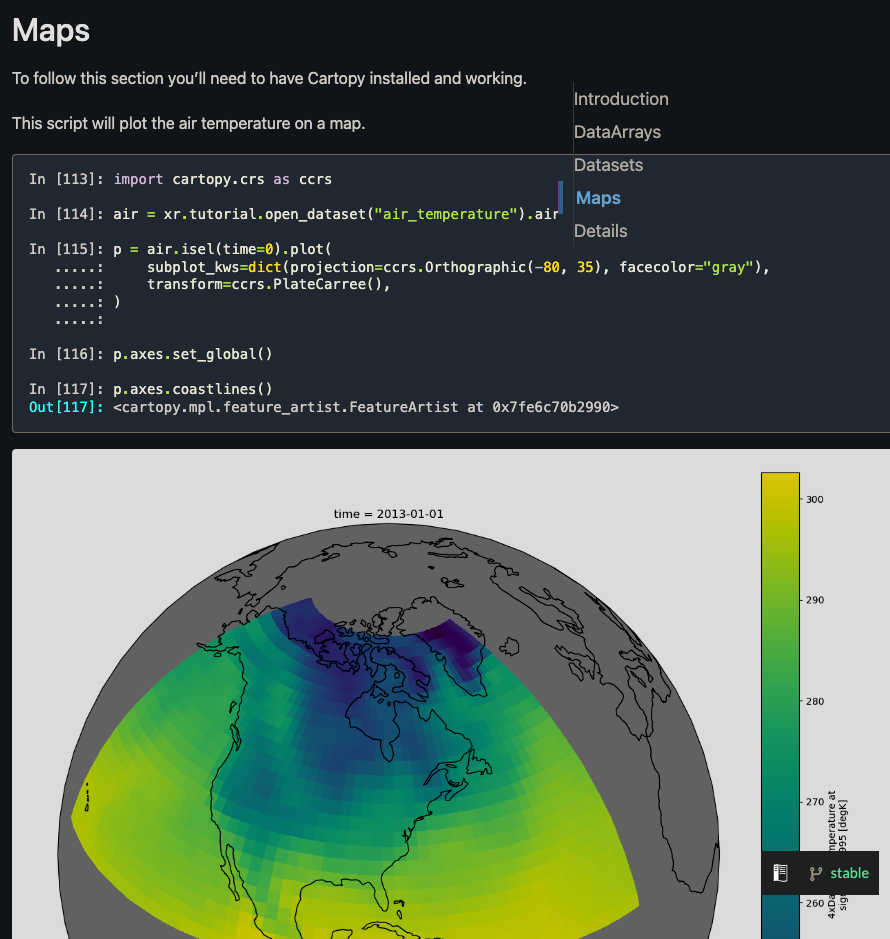

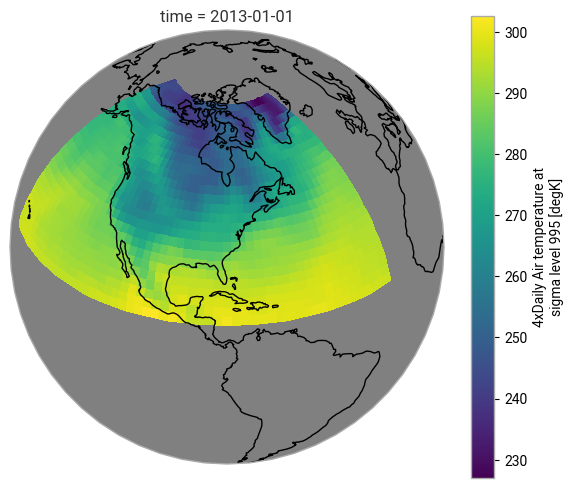

In [78]:
import cartopy.crs as ccrs

air = xr.tutorial.open_dataset("air_temperature").air

p = air.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)


p.axes.set_global()

p.axes.coastlines()

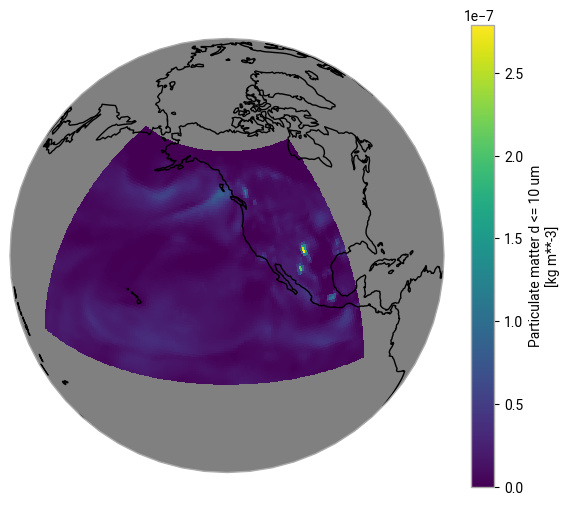

In [83]:
pm10_map = ds_xr["pm10"].plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-130, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

pm10_map.axes.set_global()
pm10_map.axes.coastlines()



# [regionmask](https://regionmask.readthedocs.io/en/stable/)

We'll use a scientific region defined in regionmask's documentation: https://regionmask.readthedocs.io/en/stable/defined_scientific.html

In [9]:
import regionmask

In [10]:
regionmask.defined_regions.ar6.all

<regionmask.Regions 'AR6 reference regions'>
Source:   Iturbide et al., 2020 (ESSD)
overlap:  False

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

<GeoAxes: >

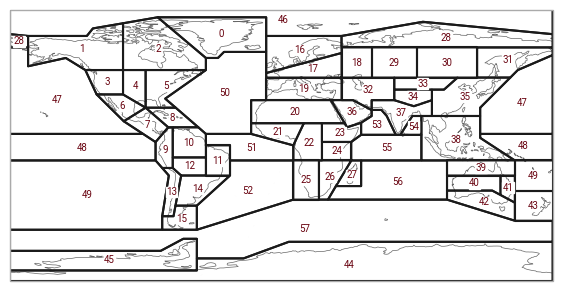

In [11]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regionmask.defined_regions.ar6.all.plot(
    text_kws=text_kws, label_multipolygon="all"
)

In [12]:
for region in regionmask.defined_regions.ar6.all:
    if region.number == 47:
        break

region

<regionmask._OneRegion: N.Pacific-Ocean (NPO / 47)>

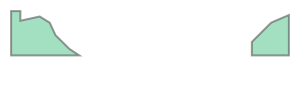

In [13]:
region.polygon

In [14]:
region.coords

array([[ 132.        ,    7.6       ],
       [ 132.        ,    8.035     ],
       [ 132.        ,    8.47      ],
       ...,
       [-179.12139303,    7.6       ],
       [-179.56069652,    7.6       ],
       [-180.        ,    7.6       ]], shape=(1027, 2))

## filtering region mask on climate data

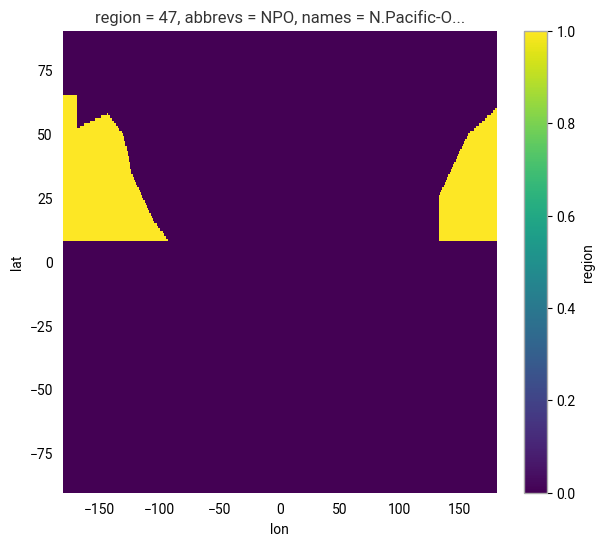

In [17]:
import regionmask

# Define the region using regionmask
ar6_regions = regionmask.defined_regions.ar6.all

# Create a mask for a specific region (e.g., region 1)
mask = ar6_regions.mask_3D(xr.Dataset({'lon': (['lon'], np.linspace(-179.99, 180, 360)),
                                       'lat': (['lat'], np.linspace(-90, 90, 180))}))

mask.sel(region=47).plot()


In [18]:
mask.sel(region=47)

<xarray.DataArray 'mask' (lat: 180, lon: 360)> Size: 65kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(180, 360))
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
    region   int64 8B 47
    abbrevs  <U4 16B 'NPO'
    names    <U25 100B 'N.Pacific-Ocean'
Attributes:
    standard_name:  region

(array([5.0784447e+07, 3.3321330e+06, 2.7890100e+05, 3.4251000e+04,
        2.4465000e+04, 9.7860000e+03, 4.8930000e+03, 9.7860000e+03,
        0.0000000e+00, 9.7860000e+03]),
 array([0.00000000e+00, 2.79239742e-08, 5.58479485e-08, 8.37719227e-08,
        1.11695897e-07, 1.39619871e-07, 1.67543845e-07, 1.95467820e-07,
        2.23391794e-07, 2.51315768e-07, 2.79239742e-07]),
 <BarContainer object of 10 artists>)

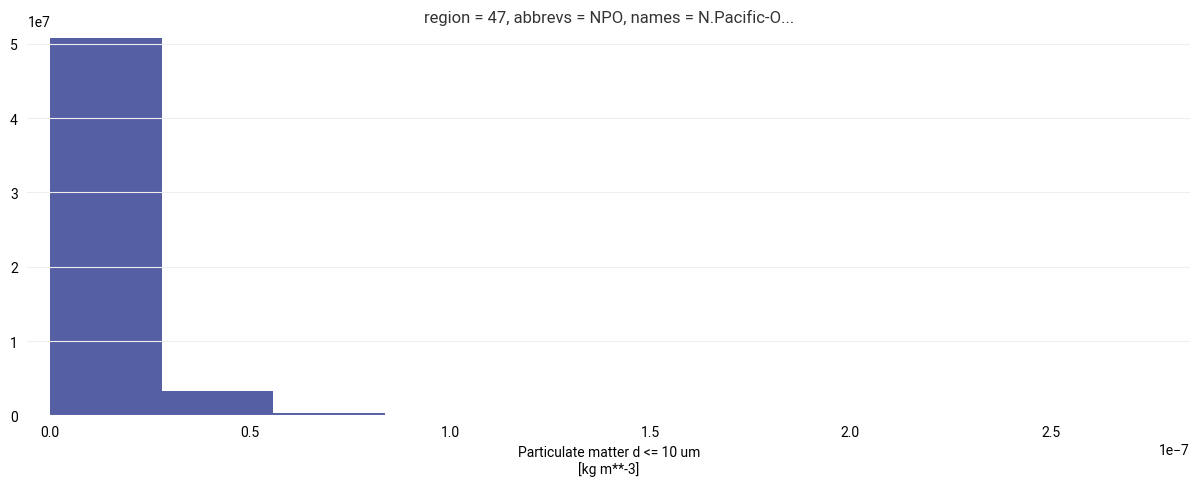

In [ ]:
# Apply the mask to the climate data
masked_climate_data = ds.to_xarray().where(mask.sel(region=47))

# Plot the masked data
masked_climate_data["pm10"].plot(figsize=(15, 5))

(array([1404291., 5984139., 6537048., 9135231., 7222068., 7593936.,
        5098506., 8000055., 2515002.,  998172.]),
 array([0.0004393 , 0.00050077, 0.00056224, 0.00062371, 0.00068518,
        0.00074665, 0.00080811, 0.00086958, 0.00093105, 0.00099252,
        0.00105399]),
 <BarContainer object of 10 artists>)

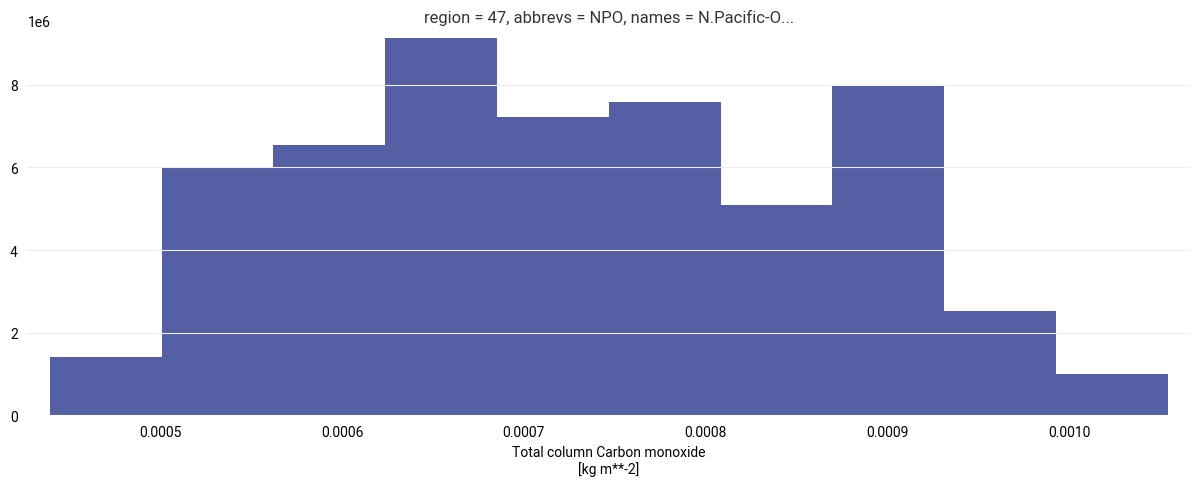

In [ ]:
masked_climate_data["tcco"].plot(figsize=(15, 5))

(array([ 1208571.,  1634262.,  1663620.,  3811647., 16827027.,  9580494.,
         9575601.,  8415960.,  1389612.,   381654.]),
 array([ 98748.6875,  99262.0625,  99775.4375, 100288.8125, 100802.1875,
        101315.5625, 101828.9375, 102342.3125, 102855.6875, 103369.0625,
        103882.4375]),
 <BarContainer object of 10 artists>)

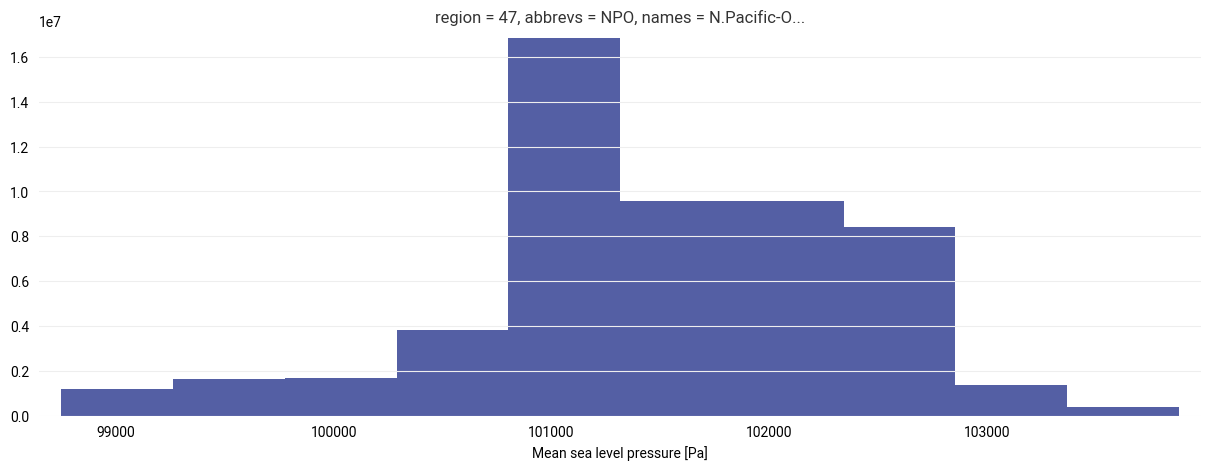

In [49]:
masked_climate_data["msl"].plot(figsize=(15, 5))

In [54]:
regionmask.defined_regions.ar6.all[47]

<regionmask._OneRegion: N.Pacific-Ocean (NPO / 47)>

## iterate over interesting regions

<regionmask._OneRegion: N.Pacific-Ocean (NPO / 47)>
<regionmask._OneRegion: Equatorial.Pacific-Ocean (EPO / 48)>
<regionmask._OneRegion: S.Pacific-Ocean (SPO / 49)>


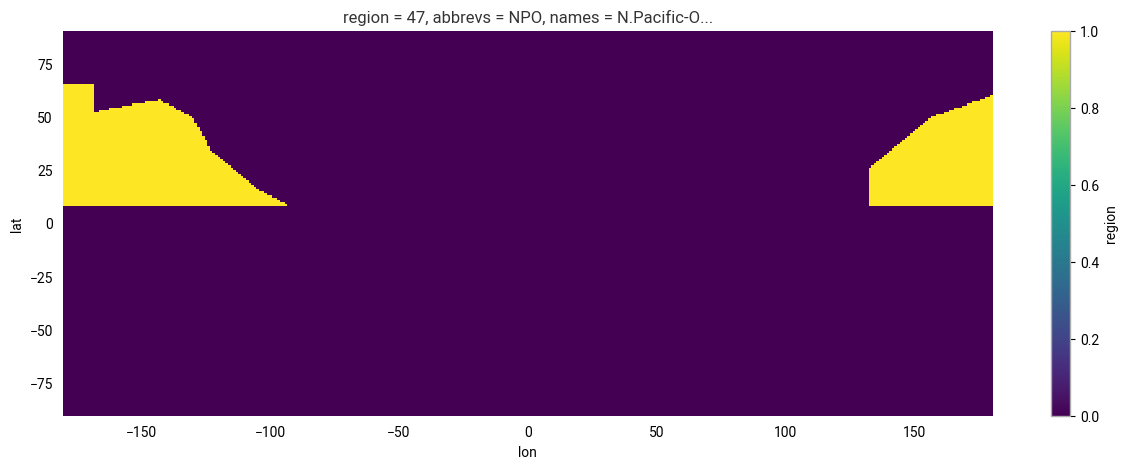

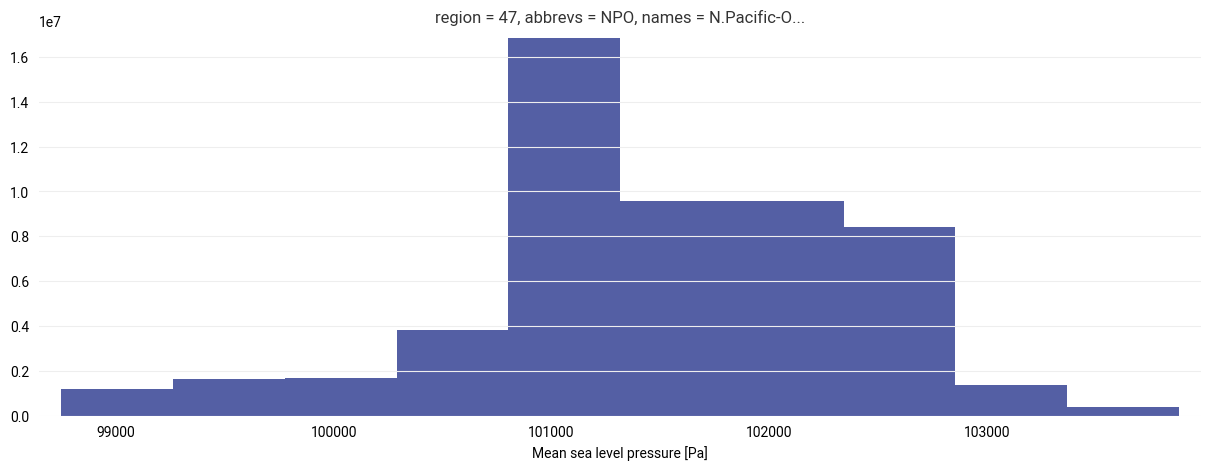

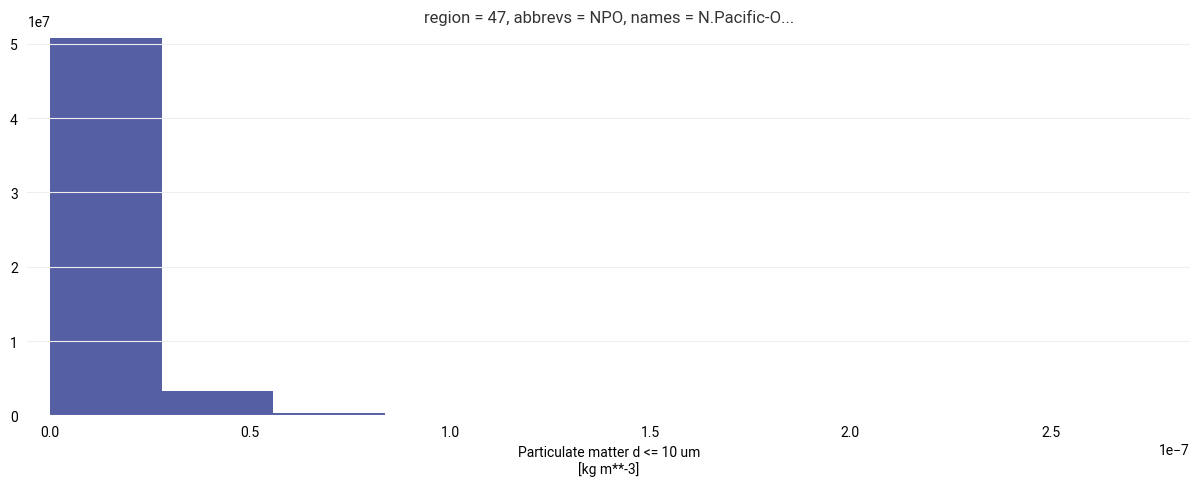

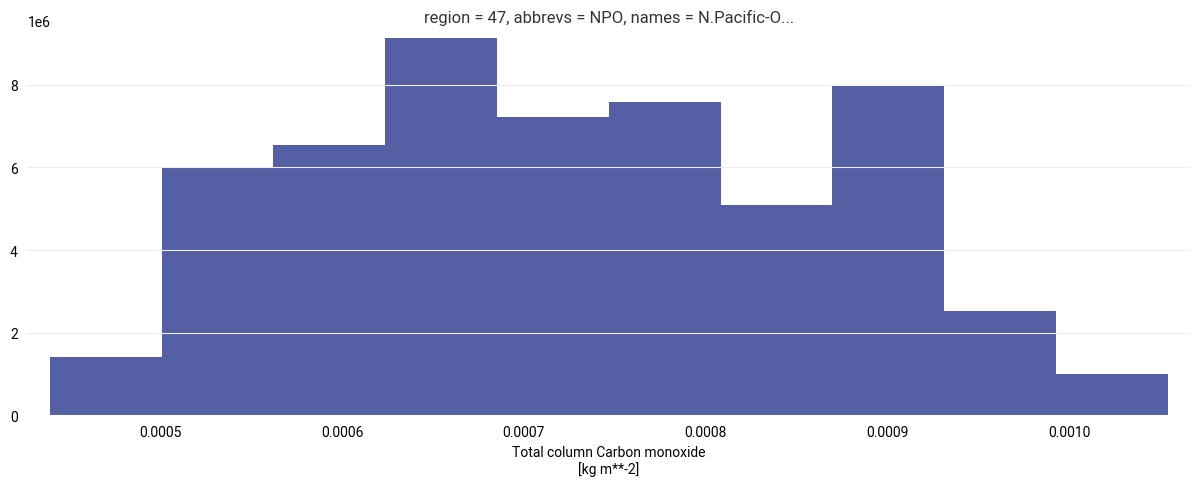

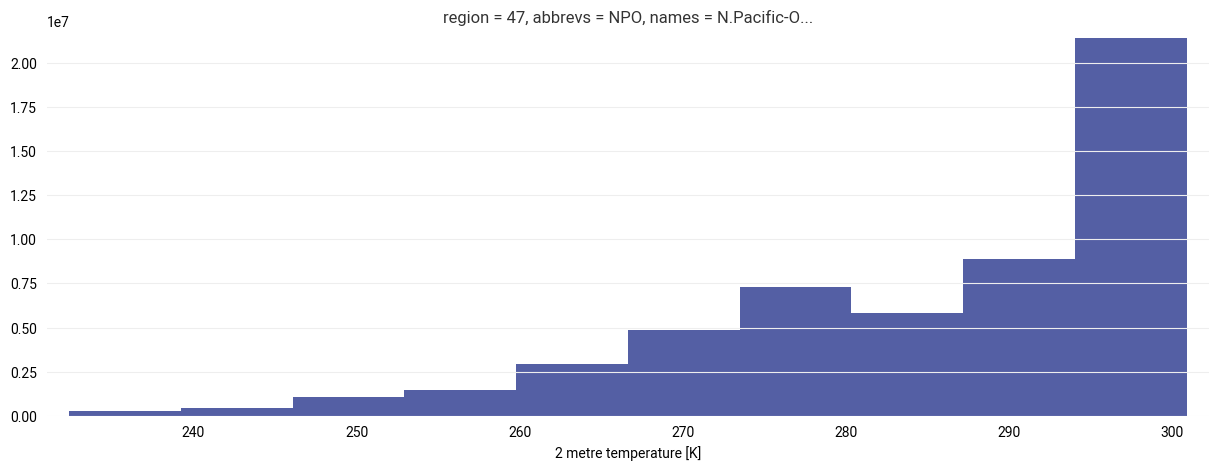

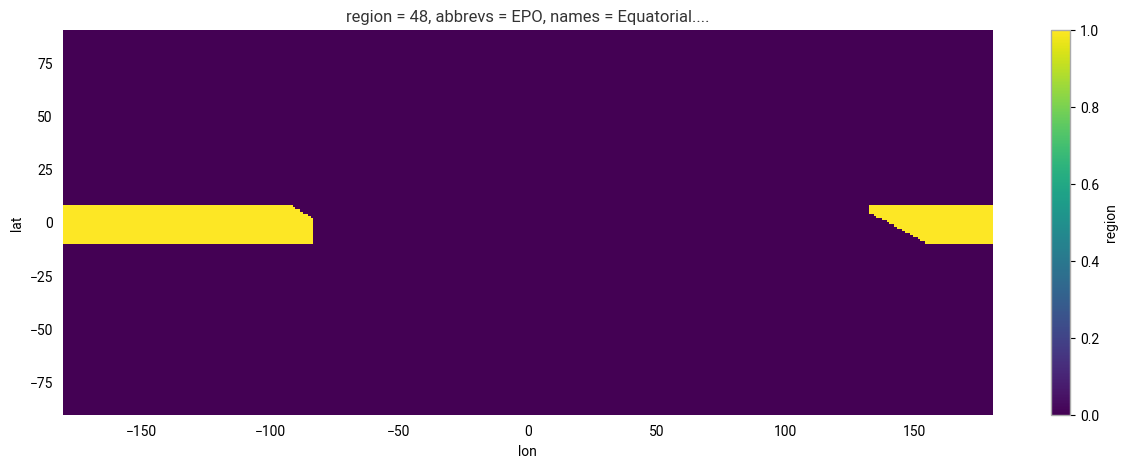

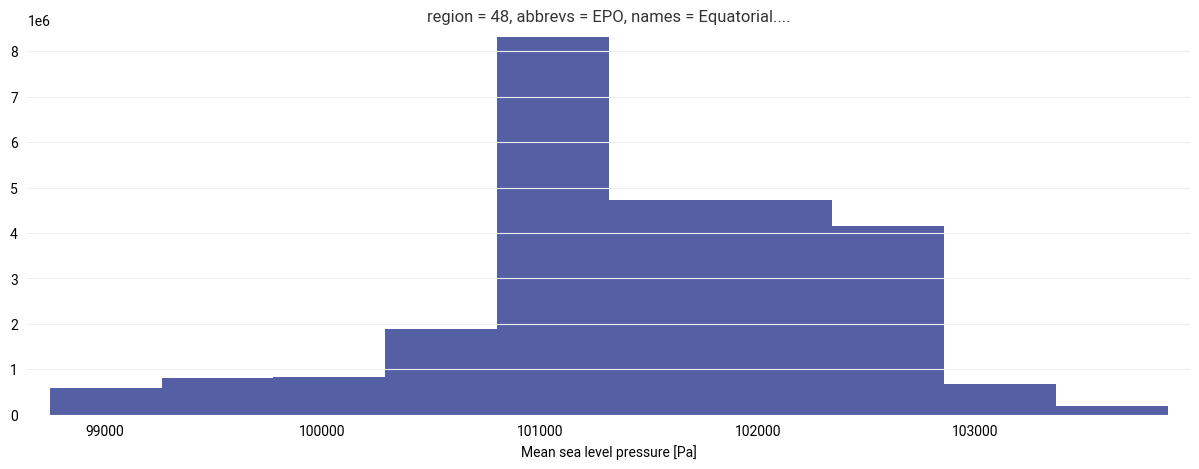

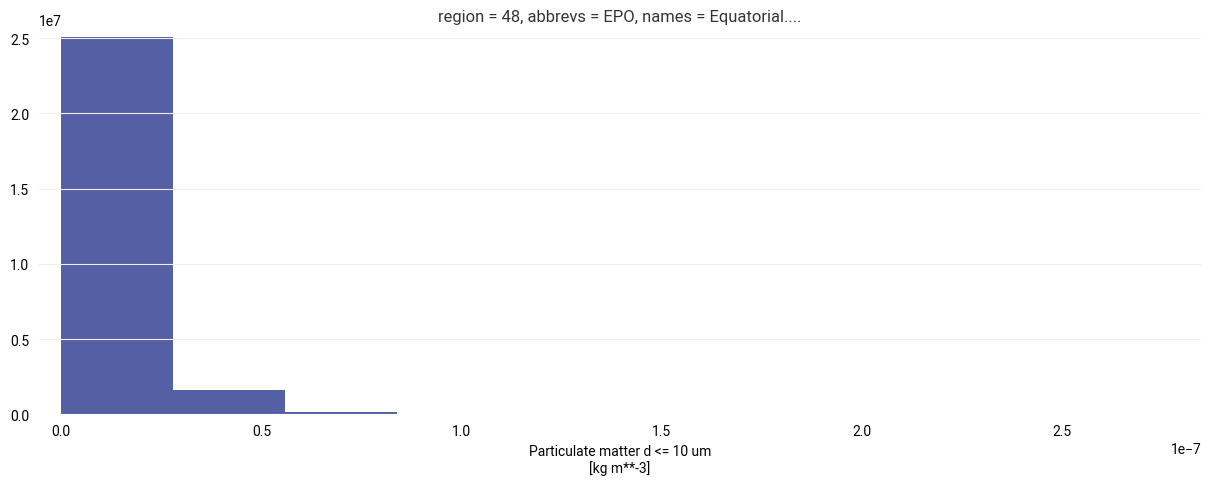

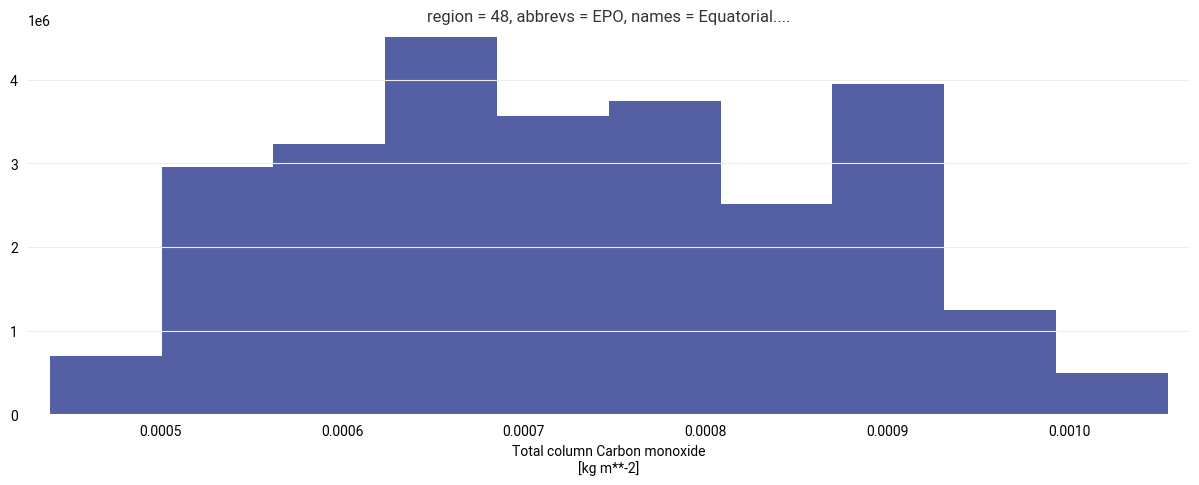

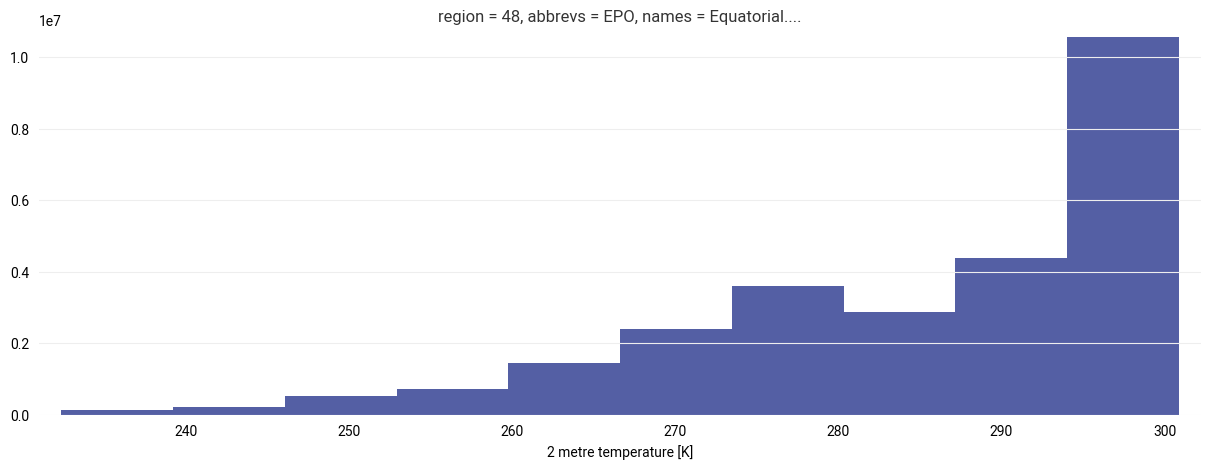

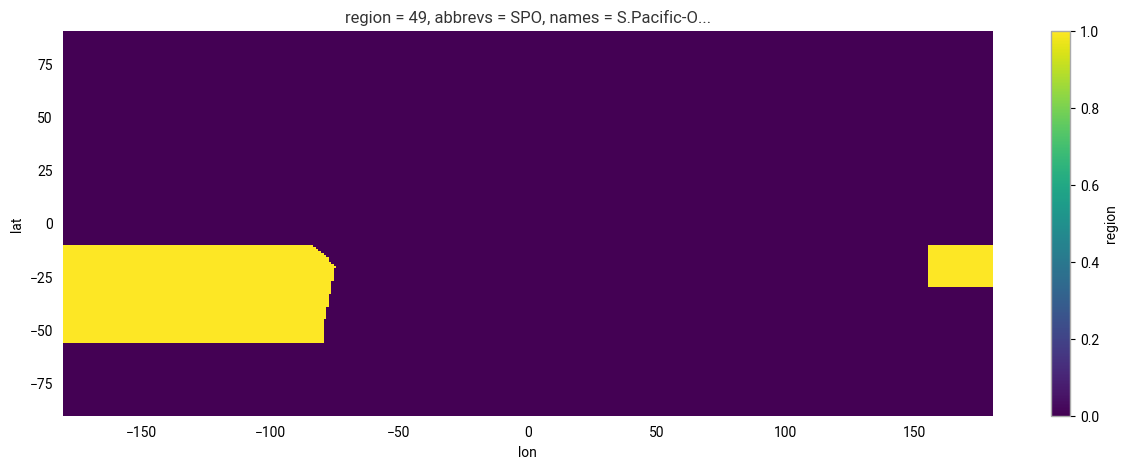

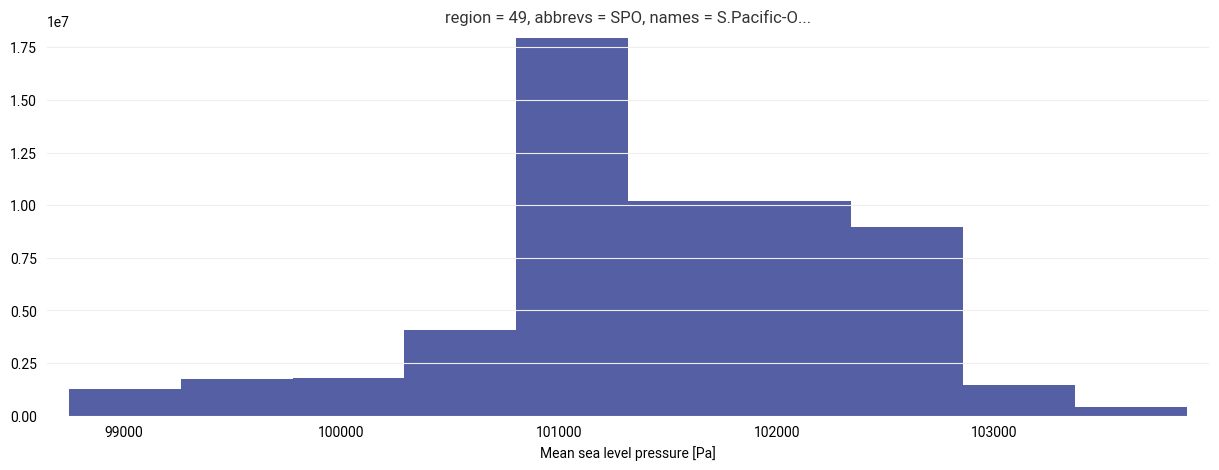

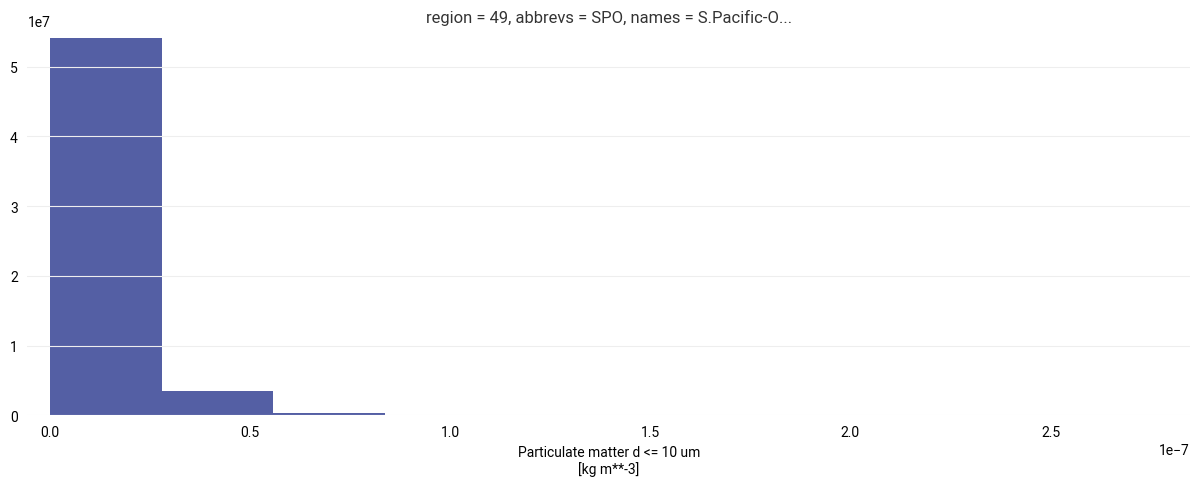

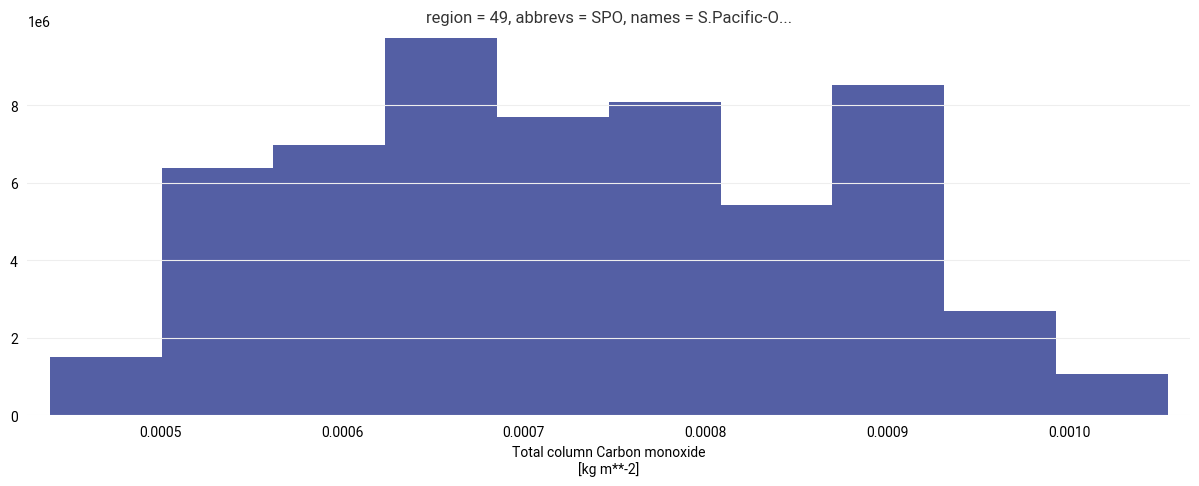

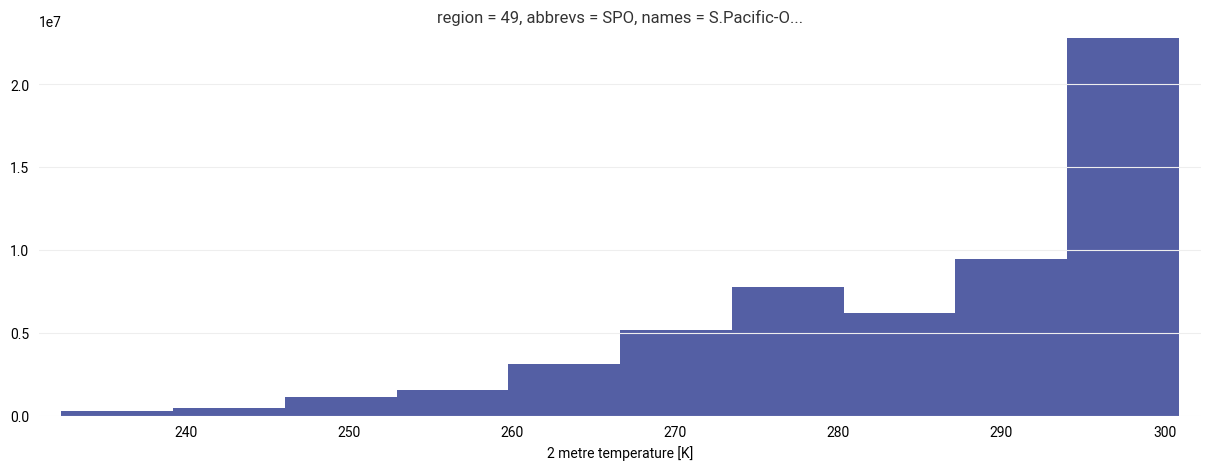

In [50]:
RELEVANT_LAND_REGIONS = [1, 3, 6, 7, 9, 13, 15]
RELEVANT_OCEAN_REGIONS = [47, 48, 49]

RELEVANT_REGIONS = RELEVANT_OCEAN_REGIONS # + RELEVANT_LAND_REGIONS


def plot_region_data(ds, region_number, variable):
    ar6_regions = regionmask.defined_regions.ar6.all

    mask = ar6_regions.mask_3D(xr.Dataset({'lon': (['lon'], np.linspace(-179.999, 180, 360)),  # est. wrap around
                                           'lat': (['lat'], np.linspace(-90, 90, 180))}))

    region_mask = mask.sel(region=region_number)

    masked_ds = ds.to_xarray().where(region_mask)
    masked_ds[variable].plot(figsize=(15, 5))


for region_number in RELEVANT_REGIONS:
    plot_region_data(ds, region_number, "pm10")


        
